# Final assignment of “Management and Analysis of Physics Datasets”
# - Part 2 

## Group:
## Giacomo Barzon (1207274) 
## Delfina Iriarte ()
## Karan Kabbur Hanumanthappa Manjunatha (1236383)

# Assignment 1: Redundancy

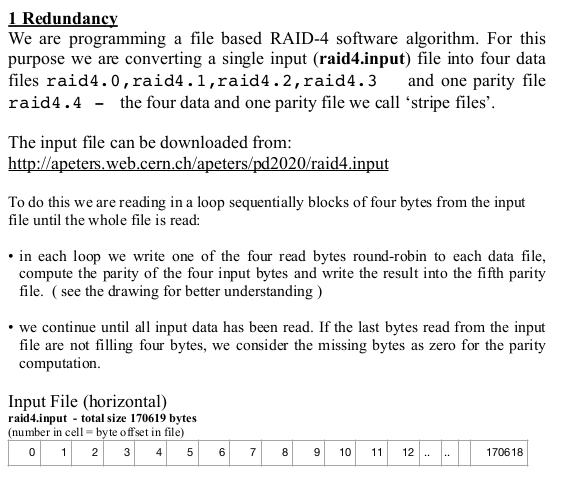

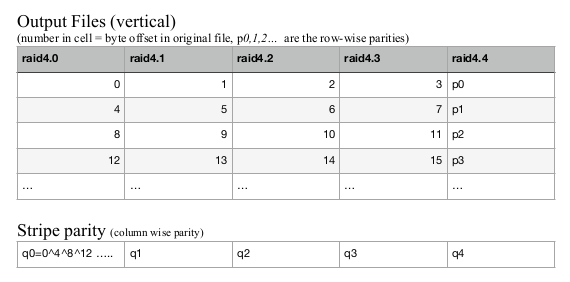

## 1.1 Write a program, which produces four striped data and one parity file

In [1]:
input_file = './raid4.input'
raid4 = open(input_file,'rb') # here b in 'rb' refers to binary
size_original = len(raid4.read())

# we open() input file again since after using raid4.read() it emtpies all the contents from raid4  
raid4 = open(input_file,'rb') # here b in 'rb' refers to binary
print(size_original)
# There are 170619 bytes in raid4.input file. We need to pick each byte and put them sequentially into 4 raid files
# given by raid4.0, raid4.1, raid4.2, raid4.3

170619


In [2]:
print(170619 % 4)
print(170620 % 4)
# 170619 is not divisible by 4 while 170620 is. So, the last byte which is not present for raid4.3 file is taken
# as 0 in bytes as given in assignment question.

3
0


In [94]:
size = size_original + (4-(size_original%4)) # create the number of bytes whose length is divisible by 4,
#so that all output files are filled equally. The last output files gets filled with zero i.e. b'\x00'
size

170620

In [95]:
#read the contents of raid4.input file as bytes. Each time we use raid.read(1) in loop
# we actually move to next byte 
# courtesy: https://stackoverflow.com/questions/23234333/buffer-size-vs-file-size-when-reading-binary-file-in-python 

# create 4 files to write the data as seen in table in assignment question
raid = [open("raid4.0","wb"),open("raid4.1","wb"),open("raid4.2","wb"),open("raid4.3","wb")]

j = 0
for i in range(size): 
    if i>=size_original:
        raid[j].write(b'\x00') # we fill the last files with 0's as bytes, so that parity operation is possible.
        j+=1
        if j==4:
            j=0
    else:
        byte = raid4.read(1) # ssequentially read those bytes
        raid[j].write(byte) # Sequentially put those bytes in those four files.
        j+=1
        if j==4: # index j can be 0,1,2,3 representing the 4 files 
            j=0

# close all the files
for i in range(4):
    raid[i].close()

In [96]:
# Row-wise parity: raid4.4
raid_row = open("raid4.4","wb")

raid = [open("raid4.0","rb"),open("raid4.1","rb"),open("raid4.2","rb"),open("raid4.3","rb")]

# read all the contents of the raid files and zip them. Finally, loop them together by doing combined XOR operation
raid_row.write(bytes([a^b^c^d for a,b,c,d in zip(raid[0].read(),raid[1].read(),raid[2].read(),raid[3].read())]))
raid_row.close()


In [97]:
# Another way to do it one by one at a time
raid = [open("raid4.0","rb"),open("raid4.1","rb"),open("raid4.2","rb"),open("raid4.3","rb")]

# Using XOR directly on raid[i].read(1) bytes(ascii) is not possible in python, so we take this route
# ord() takes in the bytes which are read and converts them into integer, and we do XOR over these.
# chr() converts the xorred integer value into character.
bytes(chr(ord(raid[0].read(1)) ^ ord(raid[1].read(1))^ord(raid[2].read(1))^ord(raid[3].read(1))),'utf-8')

b'w'

## 1.2 Extend the program to compute additionally the parity of all bytes within one stripe file. You can say, that the computed column-wise parity acts as a ________ for each stripe file. Compute the size overhead by comparing the size of all 5 stripe files with the original file. The size overhead is ________ % !

In [98]:
def col_parities(fname,format_type = 'utf-8'):
    raid = open(fname,'rb')
    bytes_list = []
    for i in range(size//4): # each stripe file has size//4 number of contents
        bytes_list.append(ord(raid.read(1))) # ord gives numerical values to those bytes
    #print(bytes_list[:10])

    # compute the parity of each stripe file
    par = bytes_list[0]
    for i in range(1,size//4): 
        par ^= bytes_list[i]
        
    if 'utf-8' == format_type:
        return (bytes(chr(par),'utf-8')) # chr converts it into character ASCII. Bytes takes the chr as input and gives
                                    # in bytes.
    if 'hex' == format_type:
        return hex(par) # to get only in hex code format and not unicode hex. see-->https://www.utf8-chartable.de/

# open a file and write the column parities of each stripe file in that.    
col_par = open("stripeCol.5","wb")
for f in ["raid4.0","raid4.1","raid4.2","raid4.3","raid4.4"]:
    col_par.write(col_parities(f))
col_par.close()

# check the contents of the above written file
col_par = open("stripeCol.5","rb")
print(col_par.read())
col_par.close()
# The computed column wise parity acts as a checksum for each stripe file.

b'\xc2\xa5\x07\xc2\xa0\xc2\x9b\xc2\x99'


The computed column wise parity acts as a checksum for each stripe file. 
 
The main concept is as follows: We detect errors by verifying the consistency of the data with the respective **"checksums"**. So you can detect errors independently and then we use all redundancy for error correction.

So, the column wise parity file ***stripeCol.5*** acts as a **"checksum"** and row wise parity file ***raid4.4*** acts as **"redundancy"**

In [99]:
size_original

170619

In [100]:
size_all5 = 0
for f in ["raid4.0","raid4.1","raid4.2","raid4.3","raid4.4"]:
    raid = open(f,'rb').read()
    size_all5 += len(raid) 

size_overhead = (size_all5-size_original)*100/size_original
print("The size overhead is ",size_overhead,"%")

The size overhead is  25.000732626495292 %


### 1.3 What is the 5-byte parity value if you write it it in hexadecimal format like P 5 =0x[q0][q1][q2][q3][q4], where the [qx] are the hexadecimal parity bytes computed by xor-ing all bytes in each stripe file. A byte in hexadecimal has two digits and you should add leading 0 if necessary.
### Examples
### • a byte with contents 1 in hexadecimal is 0x01. A byte with contents 255 in hexadecimal is 0xff.
### • a possible 5-byte parity would be P 5 = 0 x 01 0c 1a 2f 3e

In [101]:
raid_files = ["raid4.0","raid4.1","raid4.2","raid4.3","raid4.4"] 
five_byteParity = '0 x '
for f in raid_files:
    hex_stripeFile = col_parities(f,'hex')  
    if len(hex_stripeFile)==3:
        five_byteParity+='0'+hex_stripeFile[-1]+' '
    else:
        five_byteParity+=hex_stripeFile[-2:]+' '
    
five_byteParity

    

'0 x a5 07 a0 9b 99 '

### 1.4 If you create a sixth stripe file, which contains the row-wise parities of the five stripe files, what would be the contents of this file? Write down the equation for R, which is the XOR between all data stripes D0,D1,D2,D3 and the parity P. Remember P was the parity of D0,D1,D2,D3! Reduce the equation removing P from it to get the answer about the contents!

P = D0 ^ D1 ^ D2 ^ D3 ^ D4 

R = D0 ^ D1 ^ D2 ^ D3 ^ D4 ^ P 

But we know that P^P=0 always since by the definition of XOR, 1^1=0 and 0^0=0 that is which expresses that if only one (exclusive) of the two (or) bits is true, the result is true.

So, to get the contents we just remove the parity P in the equation: D = D0 ^ D1 ^ D2 ^ D3 ^ D4

In [102]:
raid = [open("raid4.0","rb"),open("raid4.1","rb"),open("raid4.2","rb"),open("raid4.3","rb"),open("raid4.4",'rb')]

R = (bytes([a^b^c^d^e for a,b,c,d,e in zip(raid[0].read(),raid[1].read(),raid[2].read(),raid[3].read(),
                                                   raid[4].read())]))
print(R[:10])
# We see that the contents of the file are zeros as expected.

# To get the contents we just remove P as suggested 
raid = [open("raid4.0","rb"),open("raid4.1","rb"),open("raid4.2","rb"),open("raid4.3","rb")]

D = (bytes([a^b^c^d for a,b,c,d in zip(raid[0].read(),raid[1].read(),raid[2].read(),raid[3].read())]))
print(D[:10])


b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
b'w\x01\x0e[G\xd8\x1d`&\x15'


### 1.5 After some time you recompute the 5-byte parity value as in 1.3. Now the result is P 5 = 0x ff 07 a0 9b 99. Something has been corrupted. You want to reconstruct the original file raid4.input using the 5 stripe files. Describe how you can recreate the original data file. Which stripe files do you use and how do you recreate the original data file? Why could it be useful to store also the file size somewhere?

In [103]:
five_byteParity
# we see here that stripe file 1 or raid4.0 is corrupted. We were able to detect this because column parities
# given in question and the one computed earlier in 1.3 are different.

# column wise parity of stripe files gives us Checksum, from which we detected the error.


'0 x a5 07 a0 9b 99 '

In [104]:
# a1 is the first byte of original raid4.0 which is not corrupted. 
a1=open("raid4.0","rb").read(1)
a1

b'%'

In [105]:
# Given that raid4.0 got corrupted, we get back raid4.0 by doing xor operation on files D1,D2,D3,P where
# P is the parity file and hence we are able to correct it and finally get back the raid4.0 file.
# This P file is the redundancy file from which we are able to successfully do error correction.
# Here we have shown how to get back the first byte from remaining first bytes of other files(raid4.1, raid4.2
# raid4.3, raid4.4)
b1=open("raid4.1","rb").read(1)
c1=open("raid4.2","rb").read(1)
d1=open("raid4.3","rb").read(1)
p1=open("raid4.4","rb").read(1)
bytes(chr(ord(b1)^ord(c1)^ord(d1)^ord(p1)),'utf-8')

b'%'

In [106]:
# We use the stripe files raid4.1, raid4.2, raid4.3, raid4.4 and XOR all of them to recreate raid4.0, the original
# raid4.0 file

raid_recreate = open("raid4.0.recreated","wb")

raid = [open("raid4.1","rb"),open("raid4.2","rb"),open("raid4.3","rb"),open("raid4.4","rb")]

raid_recreate.write(bytes([a^b^c^d for a,b,c,d in zip(raid[0].read(),raid[1].read(),
                                                      raid[2].read(),raid[3].read())]))
raid_recreate.close()


In [107]:
# We just compare both raid4.0 and raid4.0.recreated to check if they are the same.
raid40_recreate = open("raid4.0.recreated",'rb')
raid40_original = open("raid4.0",'rb')
print(raid40_original.read() == raid40_recreate.read())

# close files
raid40_recreate.close()
raid40_original.close()

True


In [108]:
# Now from this recreated raid4.0.recreated file, we get back the original raid4.input file.
raid = [open("raid4.0.recreated","rb"),open("raid4.1","rb"),open("raid4.2","rb"),open("raid4.3","rb")]
raid_input_recreate = open("raid4.input.recreated","wb") 

j = 0
for i in range(size): 
    if i>=size_original:
        break # we break the loop so that we don't consider the \x00 from the remaining files 
    else:
        byte = raid[j].read(1) # Sequentially take those bytes from the 4 files and put them into raid4.input.recreated
        raid_input_recreate.write(byte)
        j+=1
        if j==4:
            j=0

# close all the files
for i in range(4):
    raid[i].close()
raid_input_recreate.close()

In [109]:
# Now we just compare both raid4.input and raid4.input.recreated to check if they are the same.

raid4_input_original = open("raid4.input",'rb')
raid4_input_recreated = open("raid4.input.recreated",'rb')
print(raid4_input_original.read() == raid4_input_recreated.read())

# close files
raid4_input_original.close()
raid4_input_recreated.close()

# After recreating, we also see that the 2 pdf's input and recreated input file are exactly the same visually.

True


# 2. Cryptography

### A friend has emailed you the following text: K]amua!kvShuvt 
### She told you that her encryption algorithm works like this:
### • to each ASCII value of each letter I add a secret key value. (note that ASCII values range from 0 to 255)
### • additionally to make it more secure I add a variable (so called) nonce value to each ASCII number.
### The nonce start value is 0 for the first character of the message. For each following character I increase the nonce by 1, e.g. for the second letter the nonce added is 1, for the third letter it is 2 aso. 
#### encoded_character[i] = character[i] + key + nonce(i)

### 2.1 Is this symmetric or asymmetric encryption and explain why?

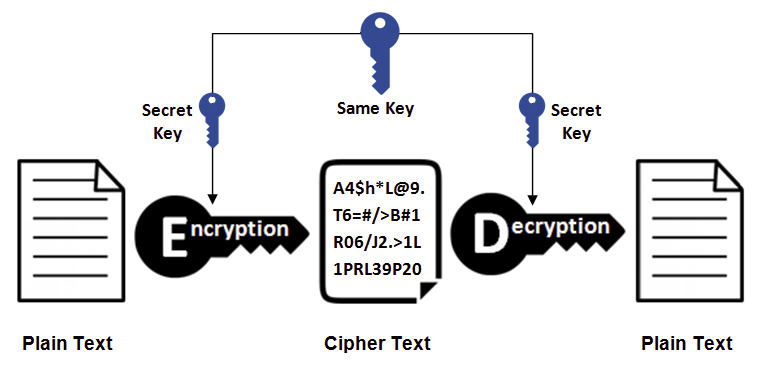

courtesy: https://www.ssl2buy.com/wiki/symmetric-vs-asymmetric-encryption-what-are-differences
This is an symmetric encryption. She first encrypts with a private key that she has. And using the same key we will be able to decrypt the message as given in the question. nonce is an additional security measure which both the sender and receiver knows and in a way it acts as a public key.

### 2.2 Write a small brute force program which tests keys from 0..255 and use a dictionary approach to figure out the original message.

In [3]:
encode = "K]amua!kv$huvt"
list(encode)

['K', ']', 'a', 'm', 'u', 'a', '!', 'k', 'v', '$', 'h', 'u', 'v', 't']

In [7]:
encode = "K]amua!kv$huvt"
letters = list(encode)

for key in range(256):
    decode = ''
    nonce = 0
    # ASCII characters have a range from 0 to 255, which in some languages is called an unsigned character type. 
# If it overflows or underflows the range, just remap it to the range from 0-255 
# YWe do this by using a module 256 operation:
    for char in letters:
        decode += chr((ord(char) - key - nonce)%256)
        nonce+=1
    print('key:',key)
    print('message: ',decode,'\n')


key: 0
message:  K\_jq\dn^jjg 

key: 1
message:  J[^ip[cm]iif 

key: 2
message:  IZ]hoZbl\hhe 

key: 3
message:  HY\gnYak[ggd 

key: 4
message:  GX[fmX`jZffc 

key: 5
message:  FWZelW_iYeeb 

key: 6
message:  EVYdkV^hXdda 

key: 7
message:  DUXcjU]gWcc` 

key: 8
message:  CTWbiT\fVbb_ 

key: 9
message:  BSVahS[eUaa^ 

key: 10
message:  ARU`gRZdT``] 

key: 11
message:  @QT_fQYcS__\ 

key: 12
message:  ?PS^ePXbR^^[ 

key: 13
message:  >OR]dOWaQ]]Z 

key: 14
P\\Y 

key: 15
message:  <MP[bMU_O[[X 

key: 16
message:  ;LOZaLT^NZZW 

key: 17
message:  :KNY`K
S]
MYYV 

key: 18
message:  9JMX_J	R\	LXXU 

key: 19
message:  8ILW^IQ[KWWT 

key: 20
message:  7HKV]HPZJVVS 

key: 21
message:  6GJU\GOYIUUR 

key: 22
message:  5FIT[FNXHTTQ 

key: 23
message:  4EHSZEMWGSSP 

key: 24
message:  3DGRYDLVFRRO 

key: 25
message:  2CFQXCKUEQQN 

key: 26
message:  1BEPWBJTDPPM 

key: 27
message:  0ADOVA IS COOL 

key: 28
message:  /@CNU@ÿHRÿBNNK 

key: 29
message

### What is the decryption algorithm/formula to be used?
character[i] = (encoded_character[i] - key - nonce(i))%256

The used key is **251**, the original message text is **Padova is cool**. 

# 3. Cloud Storage

### Assume each disk has 1TB of space, we have 10TB in total. Place as many files of 10GB size as possible to hard disks choosing random locations until one hard disk is full. Hint: a hard disk is full once you have stored hundred 10GB files.

### 3.1 Write a program in C, C++, Python or using ROOT, which simulates the placement of 10GB files to random locations and account the used space on each hard disk. Once the first hard disk is full, you stop to place files.

In [8]:
import random as random
import numpy as np
import matplotlib.pyplot as plt

random.seed(12345)

# a function to place files till one of the disk is full
def place_files(file_size):
    # create 10 hard disks
    hard_disks = [0]*10
    global entries # creating number of entries as a Global variable.
    entries=0
    
    while True:
        # choose a random number representing a hard disk where range(10) represents hard-disks
        # from 0-9.
        select = random.choice(range(10)) 
        hard_disks[select]+=file_size # file_size is either 10GB or 1GB according to the question
        if hard_disks[select]==1000: # when the number fills the disk to 1000GB, then stop
            break
        entries+=1 # increment the entry after placing each file randomly in the disks
                    
    print("Number of files managed to place: ",entries,'\n')
    percent_space = list(np.array(hard_disks)*100/1000)
    print("Percentage of total space used on all hard disks:\n",(percent_space))
    return(hard_disks) # return the list representing disks 0-9 which is filled with files of certain size.

# a function which plots the placement of 10GB files in various disks.
def plot_harddisk(file_size, hard_disks):
    mean_files = round(np.mean(hard_disks)/file_size) # mean number of files in each disk
    std_files = round(np.std(hard_disks)/file_size,2) # stdev of files in each disk
    plt.bar(range(10),hard_disks)
    plt.xticks(range(10))
    plt.xlabel('Harddisk #')
    plt.ylabel('Used space(GB)')
    plt.title('Hard-disk, file size= %dGB'%file_size)
    s = 'Entries: '+str(entries)+'\nMean files: '+str(mean_files)+'\nSTDEV files: '+str(std_files)
    plt.text(6.5,850,s,c='red')
    plt.show()

### 3.1a How many files did you manage to place?  3.1b What is the percentage of total used space on all hard disks in the moment the first disk is full?

Number of files managed to place:  829 

Percentage of total space used on all hard disks:
 [87.0, 84.0, 100.0, 81.0, 70.0, 89.0, 88.0, 78.0, 84.0, 69.0]


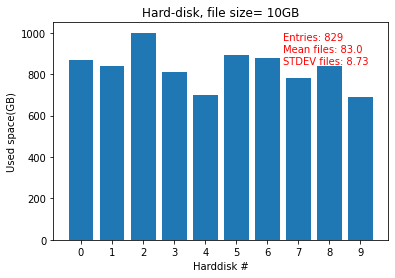

In [9]:
file_size = 10 # size of each file that is placed in GB
hard_disks = place_files(file_size)
hard_disks

plot_harddisk(file_size,hard_disks)

### 3.2 Repeat the same task placing 1GB files until the first hard disk is full.
### 3.2a How many files did you manage to place?
### 3.2b What is the percentage of total used space on all hard disks in the moment the first disk is full?

Number of files managed to place:  9605 

Percentage of total space used on all hard disks:
 [98.9, 98.3, 96.0, 93.5, 100.0, 98.9, 95.4, 89.4, 92.0, 98.2]


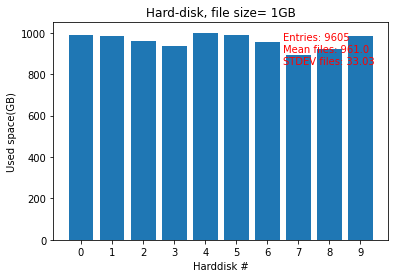

In [10]:
file_size = 1 # size of each file that is placed in GB
hard_disks = place_files(file_size)
hard_disks

plot_harddisk(file_size,hard_disks)

### 3.3 Based on this observation: why do think cloud storage typically stores fixed size blocks of 4M and not files of GBs size as a whole? ( so called block storage approach )

As we saw from the previous 2 exercises 3.1 and 3.2, with the decrease in the file size, we have better percentage of total space that is used on all hard-disks. The number of entries to each of the harddisk has also gone up because of filling in 1GB files instead of 10GB files. But if we create a blocks of 4M containing files, then it is clear that hard-disk space will be used to the fullest extent and no space is wasted/empty.